# Google Drive Mount and Install

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Genrative-Model-Tutorial

Mounted at /content/drive
/content/drive/MyDrive/Genrative-Model-Tutorial


# VEM combined with OMGD on Horse2Zebra using CycleGAN


>## OMGD

>* OMGD is an online distillation framework which jointly trains a teacher and a student.

>## Teacher Training using CycleGAN objective
![](https://drive.google.com/uc?id=1nPPyRjH_PCncmSMa7Avh8wlfKaHWEy6N)
> * The generator is trained to fool the discriminator, it wants to output data that looks _as close as possible_ to real, training data.
* The discriminator is a classifier that is trained to figure out which data is real and which is fake.

>## Student and Energy-based Model Training
![](https://drive.google.com/uc?id=1uWeSe4AmaAU4xBSN9G_d02PmzMLPJrkZ)


> * EBM is optimized to minimize the difference between the true mutual information and its lower bound esimated by EBM.

> * Student is trained to minimize the intermediate feature map and output distillation losses while maximizing the mutual information between the teacher and the studnet. In addition, we learn the student to minimize the total variation loss for spatial smoothness.

> * In this lecture, we do not implement the inintermediate feature map distillation loss, so if you want to reproduce the algorithm, please run mi_distill.sh in `./scripts/cycle_gan/horse2zebra`




# 0. Setup for downloading horse2zebra dataset

In [5]:
#@title Requirements

! pip install -r requirements.txt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.5/189.5 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.9 MB/s eta 0:00:00
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19171 sha256=a76b8d9bee725eac3c0fb6187e294bc5b0303dfba65abf3c95b8aaeb5859fd02
  Stored in directory: /root/.cache/pip/wheels/5c/d8/c0/46899f8be7a75a2ffd197a23c8797700ea858b9b34819fbf9e
 

* Download horse-zebra dataset


In [6]:
import gdown
import os

file_id = "1wMiqnCAPlXvhmpvT5x65T007fFrjRW1D"
os.makedirs('./database', exist_ok=True)
gdown.download(id=file_id,output='./database/horse2zebra.zip', quiet=False)
os.system("unzip ./database/horse2zebra.zip -d ./database")

Downloading...
From: https://drive.google.com/uc?id=1wMiqnCAPlXvhmpvT5x65T007fFrjRW1D
To: /content/drive/MyDrive/Genrative-Model-Tutorial/database/horse2zebra.zip
100%|██████████| 128M/128M [00:02<00:00, 63.0MB/s]


256

# 1. Construct the unaligned horse2zebra dataset

In [7]:
import torch.utils.data as data
import os
import torchvision.transforms as transforms
from PIL import Image
import random

IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]
def make_dataset(dir, max_dataset_size=float('inf')):
    assert os.path.isdir(dir) or os.path.islink(dir), '%s is not a valid directory' % dir
    images = []
    for root, dnames, fnames in sorted(os.walk(dir)):
        for fname in fnames:
            if any(fname.endswith(extension) for extension in IMG_EXTENSIONS):
                path = os.path.join(root, fname)
                images.append(path)
    return images[:min(max_dataset_size, len(images))]

class UnalignedDataset(data.Dataset):
    """
    This dataset class can load unaligned/unpaired datasets.

    It requires two directories to host training images from domain A '/path/to/data/trainA'
    and from domain B '/path/to/data/trainB' respectively.
    You can train the model with the dataset flag '--dataroot /path/to/data'.
    Similarly, you need to prepare two directories:
    '/path/to/data/testA' and '/path/to/data/testB' during test time.
    """
    def __init__(self, dataroot, phase='train', load_size=286, size=256):
        self.dir_A = os.path.join(dataroot, phase + 'A') # "./daabase/horse2zebra/trainA"
        self.dir_B = os.path.join(dataroot, phase + 'B') # "./daabase/horse2zebra/trainB"
        self.A_paths = sorted(make_dataset(self.dir_A)) # self.A_paths: List[str] =
        self.B_paths = sorted(make_dataset(self.dir_B))
        self.A_size = len(self.A_paths)
        self.B_size = len(self.B_paths)
        self.transform_A = self._get_transform(load_size, size)
        self.transform_B = self._get_transform(load_size, size)


    def _get_transform(self, load_size=286, size=256):
        """
        Resize an input image as load_size x load_size and then crop the resized image to size x size
        """
        transform_list = []
        resize = [load_size, load_size]
        transform_list.append(transforms.Resize(resize, Image.BICUBIC)) # Resize the input image as load_size x load_size
        transform_list.append(transforms.RandomCrop(size)) # Randomly crop the resized image to size x size
        transform_list.append(transforms.ToTensor()) # Make the cropped image whose range is in [0,1]
        transform_list.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))) # Normalize the image in [-1, 1]

        return transforms.Compose(transform_list)

    def __getitem__(self, idx_A):
        """Return a data point and its metadata information.

        Parameters:
            index (int)      -- a random integer for data indexing

        Returns a dictionary that contains A, B, A_path and B_path
            A (tensor)       -- an image in the input domain
            B (tensor)       -- an image in the target domain
            A_path (str)    -- image path for domain A
            B_path (str)    -- image path for domain B
        """

        A_path = self.A_paths[idx_A % self.A_size] # make sure index is within then range
        idx_B = random.randint(0, self.B_size - 1) # randomize the index for domain B to avoid fixed pairs.
        B_path = self.B_paths[idx_B]
        A_img = Image.open(A_path).convert('RGB') # Read image using A_path
        B_img = Image.open(B_path).convert('RGB') # Read image using B_path
        # apply image transformation
        A = self.transform_A(A_img) # use transform_A
        B = self.transform_B(B_img) # use transform_B
        return {'A': A, 'B': B, 'A_paths': A_path, 'B_paths': B_path}

    def __len__(self):
        # retunr the maximum size of dataset A and B
        return max(self.A_size, self.B_size)

## Visualize the data
We define an inverse transform that changes a tensor back to a PIL Image. First, we "unnormalize" the tensor by taking the inverse of the normalization function from above. Then, we can call ```transforms.ToPILImage()``` which will convert the tensor to a PIL Image

In [8]:
import matplotlib.pyplot as plt
# Some matplotlib settings
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams["axes.grid"] = False
plt.rcParams["xtick.major.bottom"] = False
plt.rcParams["ytick.major.left"] = False
def get_pil_img_from_tensor(img_tensor):
    inverse_transform = transforms.Compose([transforms.Normalize(mean=[-1, -1, -1], std=[1/0.5, 1/0.5, 1/0.5]),
                                            transforms.ToPILImage()])
    return inverse_transform(img_tensor)

def show_img(pil_img):
    plt.imshow(pil_img)

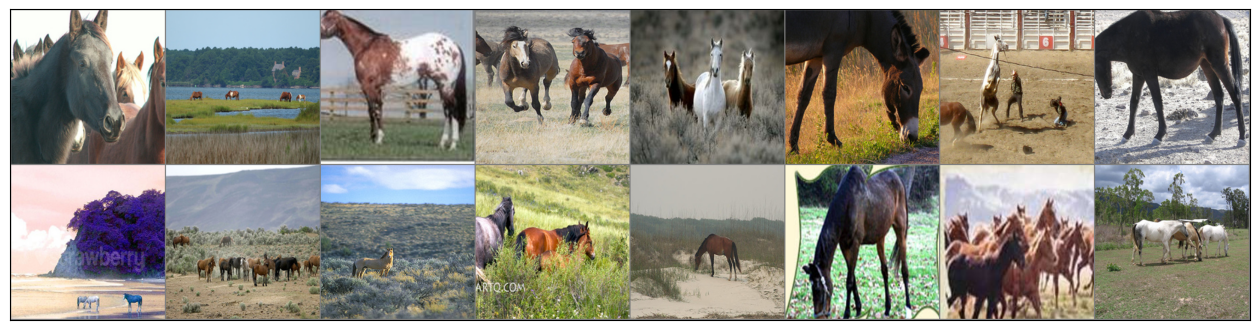

In [9]:
import torch, torchvision
dataroot = './database/horse2zebra'
horse2zebra_dataset = UnalignedDataset(dataroot= dataroot)
visualization_horse_data = torch.cat([horse2zebra_dataset[i]['A'].unsqueeze(0) for i in range(16)], 0)
show_img(get_pil_img_from_tensor(torchvision.utils.make_grid(visualization_horse_data)))


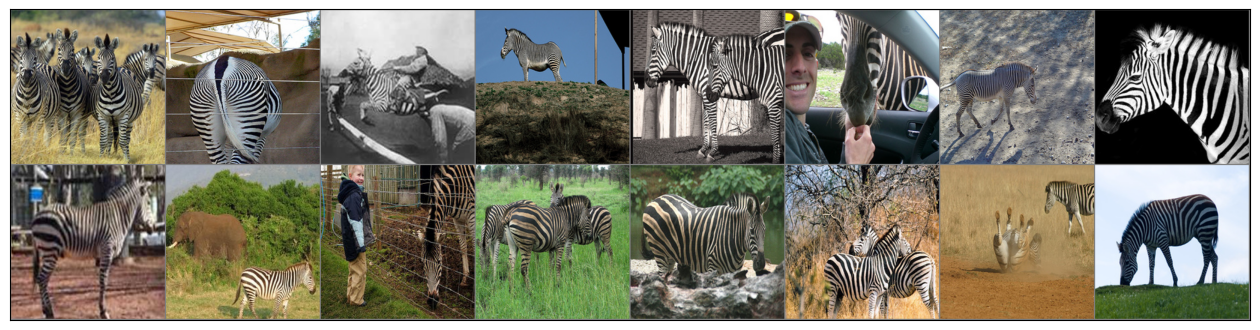

In [10]:
dataroot = './database/horse2zebra'
visualization_zebra_data = torch.cat([horse2zebra_dataset[i]['B'].unsqueeze(0) for i in range(16)], 0)
show_img(get_pil_img_from_tensor(torchvision.utils.make_grid(visualization_zebra_data)))


## Define Dataset and generate dataloaders

In [11]:
from torch.utils.data import DataLoader
# create Training DataLoader
def create_dataloader(dataroot='./database/horse2zebra', shuffle=True, batch_size=1, num_workers=4):
    horse2zebra_dataset = UnalignedDataset(dataroot= dataroot)
    dataloader = DataLoader(dataset=horse2zebra_dataset,
                              batch_size=batch_size,
                              shuffle=shuffle,
                              num_workers=num_workers)
    return dataloader



# 2. Define the model
## Component:

> ### Two discriminators (A->B and B->A)
> ### Two teacher generators (A->B and B->A)
> ### One student generator (A->B)
> ### One enrgy-based model for the student

## Define discriminator for training a teacher generator (Norm: nn.InstanceNorm2d)

![](https://drive.google.com/uc?id=12QlnJbLExv_DpeYIOsAUnd0rqL6T7qho)

### Let's create the Discriminator!

> **Exercise**: Create a generator model using nn.Conv2d(padding_mode='zeros'), nn.LeakyReLU, and nn.InstanceNorm2d function. Refer to the image above for what the network should look like!


> Refer to nn.Conv2d output size formula:
```
output_size = 1 + (input_size - kernel_size + 2*padding) / stride
```

In [12]:
import torch.nn as nn
class Discriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc, ndf=128, n_layers=3, norm_layer=nn.InstanceNorm2d):
        """Construct a PatchGAN discriminator

        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(Discriminator, self).__init__()
        use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
                    nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]
        sequence += [
            nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)
    def forward(self, input):

        return self.model(input)


In [13]:
import torch
"""
Test Code
"""

with torch.no_grad():
    Test_D = Discriminator(input_nc=3,)
    input_ = torch.randn(1,3,256,256)
    output = Test_D(input_)
    print (output.size())
    assert output.size() == (1,1,30,30), "check the network output shape"

torch.Size([1, 1, 30, 30])


## Define generator based on a residual structure (Norm: nn.InstanceNorm2d)  
![](https://drive.google.com/uc?id=1xqHoVF3NscajvJzTuSXSMm8veuWpjcp9)

###  Define the MobileResidualBlock (Norm: nn.InstanceNorm2d)
![](https://drive.google.com/uc?id=17mI_kDhJuN0sZ0qDh2PPaU7McPzsOWbB)

### Let's create the Generator!

> **Exercise**: Create a generator model using nn.Conv2d(padding_mode='reflect'), nn.ConvTranspose2d, nn.ReLU, and nn.InstanceNorm2d function. Refer to the image above for what the network should look like!

> nn.Conv2d output size formula:
```
output_size = 1 + (input_size - kernel_size + 2*padding) // stride
```

>nn.ConvTranspose2d size formula
```
output_size = 1 + (input_size − 1) × stride − 2×padding + (kernel_size - 1) + output_padding
```

>In case of depthwise cconvolution, you can employ nn.Conv2d(groups=in_channels), where 'in_channels' denotes the number of the input feature maps.

In [14]:
import torch.nn as nn
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, norm_layer, stride=1, scale_factor=1):
        super(SeparableConv2d, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels * scale_factor, kernel_size=kernel_size,
                      stride=stride, padding=padding, padding_mode='reflect', groups=in_channels, bias=True),
            norm_layer(in_channels * scale_factor),
            nn.Conv2d(in_channels=in_channels * scale_factor, out_channels=out_channels,
                      kernel_size=1, stride=1, bias=True),
        )

    def forward(self, x):
        return self.conv(x)

class MobileResnetBlock(nn.Module):
    def __init__(self, dim, norm_layer):
        super(MobileResnetBlock, self).__init__()

        conv_block = [
            SeparableConv2d(in_channels=dim, out_channels=dim,
                            kernel_size=3, padding=1, norm_layer=norm_layer, stride=1),
            norm_layer(dim), nn.ReLU(True)
        ]

        conv_block += [
            SeparableConv2d(in_channels=dim, out_channels=dim,
                            kernel_size=3, padding=1, norm_layer=norm_layer, stride=1),
            norm_layer(dim)
        ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf, norm_layer=nn.InstanceNorm2d, n_blocks=9):
        super(Generator, self).__init__()
        model= [nn.Conv2d(input_nc, ngf, kernel_size=7, padding=3, padding_mode='reflect', bias=True),
                norm_layer(ngf),
                nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling laye
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=True),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]
        mult = 2 ** n_downsampling
        for i in range(n_blocks):
            model += [MobileResnetBlock(ngf * mult, norm_layer,
                                        )]


        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        #model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=3, padding_mode='reflect', bias=True)]
        model += [nn.Tanh()]
        self.model = nn.Sequential(*model)
    def forward(self, input):
        return self.model(input)


In [15]:
import torch
"""
Test Code
"""
with torch.no_grad():
    Test_G = Generator(input_nc=3, output_nc=3, ngf=64)
    input_ = torch.randn(1,3,256,256)
    output = Test_G(input_)
    print (output.size())
    assert output.size() == (1,3,256,256), "check the network output shape"

torch.Size([1, 3, 256, 256])


## Define energy-based model


In [16]:
import torch
from util import ResnetEBM
with torch.no_grad():
    Test_ebm = ResnetEBM(8, 7)
    t_input = torch.randn([1,3,256,256])
    s_input = torch.randn([1,3,256,256])
    output = Test_ebm(t_input, s_input)
    print (output.size())
    assert output.size() == (1,1), "check the network output shape"

torch.Size([1, 1])


# Model Creator

In [17]:
def create_model(Teacher_G_ngf=64, Student_G_ngf=16, Teacher_D_ndf=128, ebm_input_nc=8, device='cuda'):

    # Instantiate Teacher (A->B & B->A) and Student (A->B)) generators
    netG_teacher_A = Generator(input_nc=3, output_nc=3, ngf=Teacher_G_ngf, norm_layer=nn.InstanceNorm2d, n_blocks=9) # (A->B)
    netG_teacher_B = Generator(input_nc=3, output_nc=3, ngf=Teacher_G_ngf, norm_layer=nn.InstanceNorm2d, n_blocks=9) # (B->A)
    netG_student = Generator(input_nc=3, output_nc=3, ngf=Student_G_ngf, norm_layer=nn.InstanceNorm2d, n_blocks=9) # (A->B)

    # Instantiate Discriminators for training Teacher Generators
    netD_teacher_A = Discriminator(input_nc=3, ndf=Teacher_D_ndf) # netD_teacher_A v.s. netG_teacher_A
    netD_teacher_B = Discriminator(input_nc=3, ndf=Teacher_D_ndf) # netD_teacher_B v.s. netG_teacher_B


    # Instantiate Energy-based Model for mutual information maximization
    netEBM = ResnetEBM(nec=ebm_input_nc, n_blocks=7) #

    # Cast to appropriate device.
    netG_teacher_A.to(device)
    netG_teacher_A.train()
    netG_teacher_B.to(device)
    netG_teacher_B.train()
    netG_student.to(device)
    netG_student.train()
    netD_teacher_A.to(device)
    netD_teacher_A.train()
    netD_teacher_B.to(device)
    netD_teacher_B.train()
    netEBM.to(device)
    netEBM.train()
    print('Models loaded on {}'.format(device))

    return netG_teacher_A, netG_teacher_B, netG_student, netD_teacher_A, netD_teacher_B, netEBM



In [18]:
# Device Settings
device = 'cuda' if torch.cuda.is_available() else 'cpu'
netG_teacher_A, netG_teacher_B, netG_student, netD_teacher_A, netD_teacher_B, netEBM = \
create_model()

Models loaded on cuda


# 3. Define the loss functions

## 3.1 Teacher Objective
![](https://drive.google.com/uc?id=1nPPyRjH_PCncmSMa7Avh8wlfKaHWEy6N)

> * The generator is trained to fool the discriminator, it wants to output data that looks _as close as possible_ to real, training data.
* The discriminator is a classifier that is trained to figure out which data is real and which is fake.

We use LSGAN loss for training teacher discriminators instead of the logistic loss.

Let's design the discriminator loss using the following LSGAN loss equation
![](https://drive.google.com/uc?id=1bBE564KBTHnMJG13dwplz-U5Cv2UJhVy)

But, our discriminator output is not a scalar value. To address the issue, we naively apply the LSGAN loss to the discriminator output at each pixel and then average them over all pixels.

### Let's design the LSGAN loss!

> **Exercise**: Create a LSGAN loss using the above equation.

In [19]:
def discriminator_lsgan_loss(D_out_real, D_out_fake):
    #loss_for_real = -torch.mean(torch.min(D_out_real - torch.ones_like(D_out_real), torch.zeros_like(D_out_real)))
    #loss_for_fake = -torch.mean(torch.min(-D_out_fake - torch.ones_like(D_out_fake), torch.zeros_like(D_out_fake)))
    loss_for_real = torch.nn.functional.mse_loss(D_out_real, torch.ones_like(D_out_real))
    loss_for_fake = torch.nn.functional.mse_loss(D_out_fake, torch.zeros_like(D_out_fake))
    loss_dis = loss_for_real + loss_for_fake
    return loss_dis

def discriminator_loss_for_fake(D_out_fake):
    #loss_gen = -torch.mean(-D_out_fake)
    #loss_gen = -torch.mean(torch.min(D_out_fake - torch.ones_like(D_out_fake), torch.zeros_like(D_out_fake)))
    loss_gen = torch.nn.functional.mse_loss(D_out_fake, torch.ones_like(D_out_fake))
    return loss_gen

Let's design the cycle_consistency loss based on L1 loss
![](https://drive.google.com/uc?id=1FvVJ172ptRMXUaNRofGnV5eNu5tuu2HE)

### Let's design the cycle consistency loss!

> **Exercise**: Create a cycle consistency loss using the above equation.

In [20]:
 def cycle_consistency_loss(real_im, reconstructed_im):
    # real_im: x^A
    # reconstructed_im: G^B(G^A(x^A))

    loss_cycle = nn.functional.l1_loss(real_im, reconstructed_im)
    return loss_cycle

## 3.2 Student Objective

### 3.2.1. Output distillation loss based on 'Style loss' and 'Feature reconstruction loss' using VGG features of  teacher and student outputs

First, define the Vgg Feature extractor as below

In [21]:
import torch
import torch.nn as nn
from torchvision import models


class Vgg16(nn.Module):
    def __init__(self):
        super(Vgg16, self).__init__()
        features = models.vgg16(pretrained=True).features
        self.to_relu_1_2 = nn.Sequential()
        self.to_relu_2_2 = nn.Sequential()
        self.to_relu_3_3 = nn.Sequential()
        self.to_relu_4_3 = nn.Sequential()

        for x in range(4):
            self.to_relu_1_2.add_module(str(x), features[x])
        for x in range(4, 9):
            self.to_relu_2_2.add_module(str(x), features[x])
        for x in range(9, 16):
            self.to_relu_3_3.add_module(str(x), features[x])
        for x in range(16, 23):
            self.to_relu_4_3.add_module(str(x), features[x])

        # don't need the gradients, just want the features
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        h = self.to_relu_1_2(x)
        h_relu_1_2 = h
        h = self.to_relu_2_2(h)
        h_relu_2_2 = h
        h = self.to_relu_3_3(h)
        h_relu_3_3 = h
        h = self.to_relu_4_3(h)
        h_relu_4_3 = h
        out = (h_relu_1_2, h_relu_2_2, h_relu_3_3, h_relu_4_3)
        return out


class VGGFeature(nn.Module):
    def __init__(self):
        super(VGGFeature, self).__init__()
        self.add_module('vgg', Vgg16())
    def __call__(self,x):
        x = (x.clone()+1.)/2. # [-1, 1] -> [0,1] (Normalize the inpu data)
        x_vgg = self.vgg(x)
        return x_vgg

Second, define the gram matrix of x, which is slightly differnet from the definition, so please refer to the following equation.
![](https://drive.google.com/uc?id=1moWsECgoMIU5P9Nd1esPaGKE4eB9Wtjg)

### Let's implement the Gram matrix!

> **Exercise**: Create a function to compute the gram matrix using the above equation (Hint: use torch.bmm).

In [22]:
def gram(x):
        (bs, ch, h, w) = x.size()
        f = x.view(bs, ch, w*h)
        f_T = f.transpose(1, 2)
        G = f.bmm(f_T) / (ch * h * w)
        return G

Third, define the style loss based on the teacher generated image (t) and the student generated image (s) using the above gram matrix as follows:
![](https://drive.google.com/uc?id=1C1Qv2n4Tqrzy_O2fL3ayCMarny7cXGRH)

### Let's design the style loss!
> **Exercise**: Create a style loss using the above equation.

In [23]:
 def style_loss_for_student(student_vgg_features, teacher_vgg_features):
    loss_G_style = 0
    for student_vgg_feature, teacher_vgg_feature in zip(student_vgg_features, teacher_vgg_features):
        student_gram = gram(student_vgg_feature)
        teacher_gram = gram(teacher_vgg_feature)
        loss_G_style += nn.functional.l1_loss(student_gram, teacher_gram)
    return loss_G_style

Finally, define the feature reconstruction loss which is given by
![](https://drive.google.com/uc?id=19RRhPPSbzNQI4nuCPmPRPs4v_MncF7No)


### Let's design the feature reconstruction loss!
> **Exercise**: Create a feature reconstruction loss using the above equation.

In [24]:
def feature_recon_loss_for_student(student_vgg_feature, teacher_vgg_feature):
    loss_G_recon = nn.functional.l1_loss(student_vgg_feature, teacher_vgg_feature)
    return loss_G_recon

### 3.2.2. Total variation loss to smoothness of the generated image given by the student

Let's define our total variation loss, which is slightly different from the true definition, where the variant total variation loss is given by
![](https://drive.google.com/uc?id=1T_n8keQjKjmklE60TFeZd0dmKh5WQEhr)

### Let's design the total variation loss!

> **Exercise**: Create a total variation loss using the above equation. Then, perform summation over each total variation loss over a mini-batch (Not important)

In [25]:
def total_variation(student_im):
    diff_i = torch.sum(torch.abs(student_im[:, :, :, 1:] - student_im[:, :, :, :-1]))
    diff_j = torch.sum(torch.abs(student_im[:, :, 1:, :] - student_im[:, :, :-1, :]))
    return diff_i + diff_j

### 3.2.3. Mutual Information Maximization Term

The gradient of the mutual information with respect to the student generator is given by
![](https://drive.google.com/uc?id=18HukuvROsJSsTdBZzaBT9QObWhJPUHov)

### Let's design the negative mutual information loss

> **Exercise**: Create the mutual information function such that the gradient of the loss can be expressed as the above equation.

In [26]:
def negative_mutual_information(ebm, teacher_im, MCMC_im, student_im):
    """
    Note that forward function in ebm takes two inputs
    """
    loss_G_ebm = ebm(teacher_im.detach(), student_im).mean() - \
                ebm(MCMC_im.detach(), student_im).mean()
    return loss_G_ebm

## 3.3 Energy-based Model Objective

The energy-based model is learned to minimize the difference between the true mutual information and its variational bound, which is equivalent to solve the following optimization

![](https://drive.google.com/uc?id=1R5dgtWLnsUKz2enCGeDv2jvYGpj0Mq8z)

### Let's design the energy-based model objective

> **Exercise**: Create the objective function using the above equation.

In [27]:
def objective_EBM(ebm, teacher_im, MCMC_im, student_im):
    first_output = ebm(teacher_im.detach(), student_im.detach())
    second_output = ebm(MCMC_im.detach(), student_im.detach())
    loss_EBM = first_output.mean() - second_output.mean()

    """
    For training stability, we additionally apply L2 regularization to the output
    which is helpful to encourage the output to become bounded
    """
    lambda_l2_coeff = 0.05
    loss_EBM += lambda_l2_coeff * (first_output **2 + second_output **2).mean()
    return loss_EBM

### Let's design Langevin Dynamics

> **Exercise**: Create MCMC function using the below equation.
![](https://drive.google.com/uc?id=1-EIuc_jtyRpKwiXRQBSs6Pf6OdDjxs74)

In [28]:
def MCMC(ebm, student_im, step_size=50.0, sigma=0.005, MCMC_steps=10):
    MCMC_img = torch.autograd.Variable(student_im.data.clone(), requires_grad=True)

    for k in range(MCMC_steps):
        out = ebm(MCMC_img, student_im.detach())
        gradient = torch.autograd.grad(out.sum(), [MCMC_img], only_inputs=True)[0]
        MCMC_img = MCMC_img - step_size * gradient         + sigma * torch.randn_like(MCMC_img)

    MCMC_img = MCMC_img.detach().clamp(min=-1.0, max=1.0)
    return MCMC_img

# 4. Optimizers


- We will use Adam with a initial learning rate of ```lr=0.0002``` for Generators and Discriminators.
- We will use Adam with a initial learning rate of ```lr=0.0001``` for EBM.

- In PyTorch, we pass the model's parameters into the optimizer. The model's parameters can be obtained by calling ```model.parameters()```.

- When we want to optimize the parameters of two models with one optimizer, we can simply concatenate the list of the two models' parameters and pass that into the optimizer

In [29]:
import torch.optim as optim
# Hyperparameters for Adam optimizer of CycleGANs and the student generator
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

optimizer_G_student = torch.optim.Adam(netG_student.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_G_teacher = torch.optim.Adam(list(netG_teacher_A.parameters()) + list(netG_teacher_B.parameters()), lr=lr, betas=(beta1, beta2))
optimizer_D_teacher = torch.optim.Adam(list(netD_teacher_A.parameters()) +list(netD_teacher_B.parameters()), lr=lr, betas=(beta1,beta2))


# Hyperparameters for Adam optimizer of EBM
ebm_lr=0.0001
beta1=0.0
beta2=0.999
optimizer_EBM = torch.optim.Adam(netEBM.parameters(), lr=ebm_lr, betas=(beta1, beta2))


# 5. Training

In [30]:
def set_requires_grad(net, requires_grad):
    """Set requies_grad=Fasle for the network to avoid unnecessary computations
        Parameters:
            net                   -- network
            requires_grad (bool)  -- whether the networks require gradients or not
    """
    for param in net.parameters():
        param.requires_grad = requires_grad

In [31]:
def optimize_teacher(data_i_A, data_i_B):
    # ============================================
    #            TRAIN Generators
    # ============================================


    # ============================================
    #            Forward
    # ============================================
    fake_B = netG_teacher_A(data_i_A)
    rec_A = netG_teacher_B(fake_B)
    fake_A = netG_teacher_B(data_i_B)
    rec_B = netG_teacher_A(fake_A)


    optimizer_G_teacher.zero_grad()
    optimizer_D_teacher.zero_grad()
    set_requires_grad(netD_teacher_A, False)
    set_requires_grad(netD_teacher_B, False)


    #            LSGAN Loss
    D_out_fake_A = netD_teacher_A(fake_B)
    lsgan_loss_A = discriminator_loss_for_fake(D_out_fake_A)
    D_out_fake_B = netD_teacher_B(fake_A)
    lsgan_loss_B = discriminator_loss_for_fake(D_out_fake_B)


    #            Cycle Consistency Loss
    lambda_cycle_A, lambda_cycle_B = 10.0, 10.0
    cycle_consistency_loss_A = cycle_consistency_loss(data_i_A, rec_A)
    cycle_consistency_loss_B = cycle_consistency_loss(data_i_B, rec_B)


    #            Identity_Loss (Additionally we use the identity loss defined as below)
    # Motivation: Encourage to become close to the input image and the translated image
    # For preserving the background details
    loss_identity_A = torch.nn.functional.l1_loss(fake_B, data_i_A)
    loss_identity_B = torch.nn.functional.l1_loss(fake_A, data_i_B)
    lambda_idty = 10.


    #            Backward
    loss_G_teacher_A = lsgan_loss_A + cycle_consistency_loss_A * lambda_cycle_A
    loss_G_teacher_B = lsgan_loss_B + cycle_consistency_loss_B * lambda_cycle_B
    loss_G_teacher = loss_G_teacher_A + loss_G_teacher_B + lambda_idty * (loss_identity_A + loss_identity_B)

    loss_G_teacher.backward()
    optimizer_G_teacher.step()


    # ============================================
    #            TRAIN Discriminators
    # ============================================
    set_requires_grad(netD_teacher_A, True)
    set_requires_grad(netD_teacher_B, True)



    #            LSGAN Loss for netD_teacher_A
    D_A_out_real = netD_teacher_A(data_i_B)
    D_A_out_fake = netD_teacher_A(fake_B.detach())
    lsgan_loss_A = discriminator_lsgan_loss(D_A_out_real, D_A_out_fake)

    #            LSGAN Loss for netD_teacher_B
    D_B_out_real = netD_teacher_B(data_i_A)
    D_B_out_fake = netD_teacher_B(fake_A.detach())
    lsgan_loss_B = discriminator_lsgan_loss(D_B_out_real, D_B_out_fake)

    #            Backward
    loss_D_teacher = 0.5 * lsgan_loss_A + 0.5 * lsgan_loss_B
    loss_D_teacher.backward()
    optimizer_D_teacher.step()


    return loss_G_teacher_A, loss_G_teacher_B, lsgan_loss_A, lsgan_loss_B


In [33]:

def optimize_student_ebm(VGGNet, student_dataloader, student_n_epoch, student_epoch, training_epochs):
    print_every=100
    lambda_style = 1e4
    lambda_feat = 1e1
    lambda_tv = 1e-5
    lambda_mi = 1e-1
    student_iter = 0
    for epoch in range(student_epoch, student_epoch + training_epochs):
        for i, data_i in enumerate(student_dataloader):
            student_iter += 1
            data_i_A = data_i['A'].to(device) # We ignore domain B data
            optimizer_G_student.zero_grad()
            optimizer_EBM.zero_grad()

            set_requires_grad(netEBM, False)

            # ============================================
            #            Forward
            # ============================================
            with torch.no_grad():
                Tfake = netG_teacher_A(data_i_A)
            Sfake = netG_student(data_i_A)

            #            sampling energy-based model samples via Langevin Dynamics
            Tfake_MCMC = MCMC(netEBM, Sfake, step_size=0.005, MCMC_steps=10)



            # ============================================
            #            TRAIN EBM
            # ============================================
            set_requires_grad(netEBM, True)
            #            Energy-based Model Loss for netEBM
            ebm_loss = objective_EBM(netEBM, Tfake, Tfake_MCMC, Sfake)
            ebm_loss.backward()
            optimizer_EBM.step()
            optimizer_EBM.zero_grad()
            i


            # ============================================
            #            TRAIN Generator
            # ============================================

            set_requires_grad(netEBM, False)
            set_requires_grad(netG_teacher_A, True)


            student_vgg_features = VGGNet(Sfake)
            teacher_vgg_features = VGGNet(Tfake)

            #            Style Loss for netG_student
            style_loss = style_loss_for_student(student_vgg_features, teacher_vgg_features)


            #            Feature Reconstruction Loss for netG_student
            student_vgg_feature = student_vgg_features[1]
            teacher_vgg_feature = teacher_vgg_features[1]
            feat_loss = feature_recon_loss_for_student(student_vgg_feature, teacher_vgg_feature)

            #            Total Variation Loss for netG_student
            total_variation_loss = total_variation(Sfake)

            #            Negative Mutual Information Loss for netG_student
            negative_mi = negative_mutual_information(netEBM, Tfake, Tfake_MCMC, Sfake)


            student_loss = lambda_style * style_loss + lambda_feat * feat_loss + \
            lambda_tv * total_variation_loss + lambda_mi * negative_mi

            student_loss.backward()
            optimizer_G_student.step()

            if student_iter % print_every == 0:
                print ('Student Loss')
                print('Epoch [{:5d}/{:5d}] | EBM_loss: {:6.4f} | Student_loss: {:6.4f}'.format(
epoch, student_n_epoch, ebm_loss.item(), student_loss.item()))


In [34]:
from util import save_network, get_scheduler, update_learning_rate

MODEL_NAMES=['netG_teacher_A', 'netG_teacher_B', 'netG_student', 'netD_teacher_A', 'netD_teacher_B', 'netEBM']
MODELS =[netG_teacher_A, netG_teacher_B, netG_student, netD_teacher_A, netD_teacher_B, netEBM]
OPTIMIZERS=[optimizer_G_student, optimizer_G_teacher, optimizer_D_teacher, optimizer_EBM]
SCHEDULERS = get_scheduler(OPTIMIZERS, 100, 100)
def training_loop(dataloader, student_dataloader, n_epochs=200):
    import time
    since = time.time()
    print_every=100
    sample_every=100
    save_latest_freq=25000

    losses = []      # keep track of losses over time


    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    total_iter = 0
    student_epoch_period = 10
    student_epochs_per_period = 40
    student_epoch = 1
    student_n_epoch = (n_epochs//student_epoch_period) * student_epochs_per_period
    VGGNet = VGGFeature().to(device)
    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        #if epoch % batches_per_epoch == 0:
            #iter_data = iter(dataloader)
        for i, data_i in enumerate(dataloader):
            total_iter += 1
            # move images to device
            data_i_A = data_i['A'].to(device)
            data_i_B = data_i['B'].to(device)


            """       Teacher Training       """
            loss_G_teacher_A, loss_G_teacher_B, loss_D_teacher_A, loss_D_teacher_B = \
            optimize_teacher(data_i_A, data_i_B)

            # Print
            if total_iter % print_every == 0:
                time_elapsed = time.time() - since
                print ('Teacher Loss')
                print('Epoch [{:5d}/{:5d}] | d_A_loss: {:6.4f} | d_B_loss: {:6.4f} | g_A_loss: {:6.4f} | g_B_loss: {:6.4f} time : {:.0f}m {:.0f}s'.format(
                    epoch, n_epochs, loss_D_teacher_A.item(), loss_D_teacher_B.item(),loss_G_teacher_A.item(), loss_G_teacher_B.item() ,time_elapsed // 60, time_elapsed % 60))

            if total_iter % save_latest_freq == 0:
                save_network(MODELS, MODEL_NAMES, 'iter_%d'%total_iter, './checkpoint')

            """
            checkpoint_every=1
            if epoch % checkpoint_every == 0:
                checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)
            """


        if epoch % student_epoch_period == 0:
            optimize_student_ebm(VGGNet, student_dataloader, student_n_epoch, student_epoch, student_epochs_per_period)
            student_epoch += student_epochs_per_period


        update_learning_rate(SCHEDULERS, OPTIMIZERS)




In [ ]:
n_epochs=200
dataloader = create_dataloader(dataroot='./database/horse2zebra', shuffle=True, batch_size=1, num_workers=4)
student_dataloader = create_dataloader(dataroot='./database/horse2zebra', shuffle=True, batch_size=1, num_workers=4)
training_loop(dataloader, student_dataloader, n_epochs)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also u

Teacher Loss
Epoch [    1/  200] | d_A_loss: 0.5444 | d_B_loss: 0.4733 | g_A_loss: 2.5487 | g_B_loss: 3.1600 time : 1m 15s
Teacher Loss
Epoch [    1/  200] | d_A_loss: 0.6435 | d_B_loss: 0.4648 | g_A_loss: 2.8605 | g_B_loss: 2.2090 time : 2m 19s
Teacher Loss
Epoch [    1/  200] | d_A_loss: 0.4279 | d_B_loss: 0.4096 | g_A_loss: 2.3223 | g_B_loss: 2.8160 time : 3m 22s
Teacher Loss
Epoch [    1/  200] | d_A_loss: 0.5204 | d_B_loss: 0.4143 | g_A_loss: 3.6058 | g_B_loss: 2.6193 time : 4m 26s
Teacher Loss
Epoch [    1/  200] | d_A_loss: 0.3876 | d_B_loss: 0.3973 | g_A_loss: 2.0183 | g_B_loss: 2.5362 time : 5m 29s
Teacher Loss
Epoch [    1/  200] | d_A_loss: 0.9737 | d_B_loss: 0.8075 | g_A_loss: 3.1392 | g_B_loss: 1.8056 time : 6m 33s
Teacher Loss
Epoch [    1/  200] | d_A_loss: 0.1815 | d_B_loss: 0.5710 | g_A_loss: 2.2928 | g_B_loss: 2.5680 time : 7m 36s
Teacher Loss
Epoch [    1/  200] | d_A_loss: 0.1005 | d_B_loss: 0.2993 | g_A_loss: 2.2536 | g_B_loss: 2.7947 time : 8m 40s
Teacher Loss
Epo